In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
import yfinance as yf
from itertools import product
!pip install arch
from arch import arch_model

In [438]:
import os
import seaborn as sns

from datetime import date
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import chi2, jarque_bera
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

# Data Description

In [442]:
# Read the file
data = pd.read_excel(file_path,parse_dates=True, index_col='Date')

# Display the first few rows of the dataframe
print(data.head())

            Gold Price   BTC Price       CPI  U.S. 10 Year Treasury Note
Date                                                                    
2013-04-01     1485.08  139.000000  0.974253                     0.01675
2013-05-01     1413.50  129.000000  1.278771                     0.02134
2013-06-01     1342.36   96.613998  1.711249                     0.02491
2013-07-01     1286.72  106.089996  1.937639                     0.02582
2013-08-01     1347.10  135.350006  1.474966                     0.02790


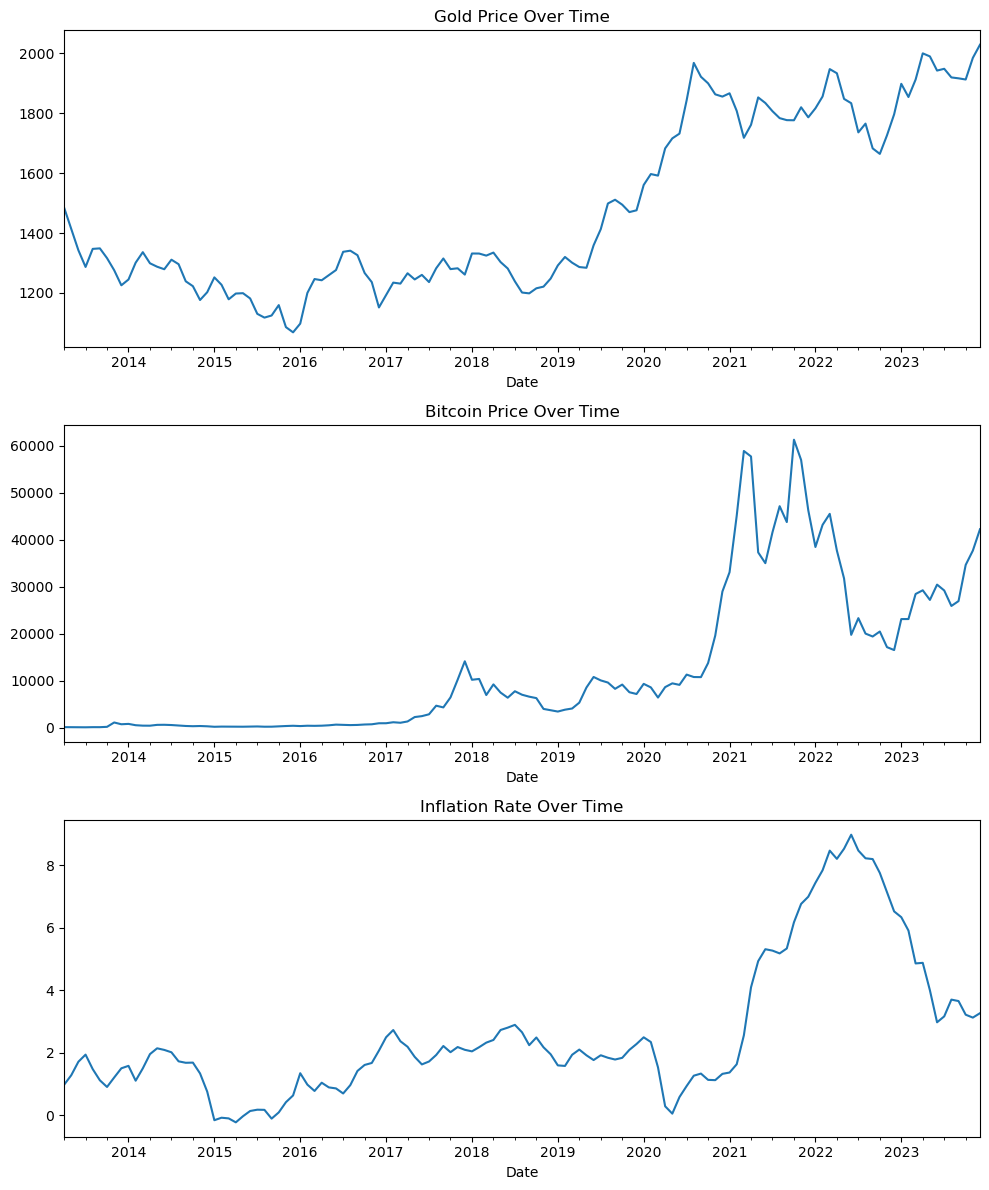

In [450]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
data['Gold Price'].plot(ax=axs[0], title='Gold Price Over Time')
data['BTC Price'].plot(ax=axs[1], title='Bitcoin Price Over Time')
data['CPI'].plot(ax=axs[2], title='Inflation Rate Over Time')
plt.tight_layout()
plt.savefig('price over time.png')
plt.show()

In [451]:
# Compute correlations
correlation_gold_inflation = pearsonr(data['Gold Price'], data['CPI'])
correlation_bitcoin_inflation = pearsonr(data['BTC Price'], data['CPI'])
print(f'Correlation between gold prices and inflation rates: {correlation_gold_inflation[0]}')
print(f'Correlation between Bitcoin prices and inflation rates: {correlation_bitcoin_inflation[0]}')

Correlation between gold prices and inflation rates: 0.618490606809508
Correlation between Bitcoin prices and inflation rates: 0.6785148397139559


In [452]:
# Download vix and S&P 500 data
vix_data = yf.download('^VIX', start='2013-04-01', end='2023-12-31')
sp500_data = yf.download('^GSPC', start='2013-04-01', end='2023-12-31')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [453]:
# Resample the data to monthly, using the mean of the daily data for simplicity
vix = vix_data['Close'].resample('MS').mean()
sp500= sp500_data['Close'].resample('MS').mean()

# Display the monthly data
print("Monthly VIX Data:")
print(vix.head())

print("\nMonthly S&P 500 Data:")
print(sp500.head())

Monthly VIX Data:
Date
2013-04-01    13.967273
2013-05-01    13.493636
2013-06-01    17.271500
2013-07-01    13.974546
2013-08-01    14.210000
Freq: MS, Name: Close, dtype: float64

Monthly S&P 500 Data:
Date
2013-04-01    1570.702265
2013-05-01    1639.842723
2013-06-01    1618.772516
2013-07-01    1668.675443
2013-08-01    1670.093639
Freq: MS, Name: Close, dtype: float64


In [454]:
monthly_vix = pd.DataFrame(vix)
monthly_sp500 = pd.DataFrame(sp500)

In [455]:
df = pd.DataFrame({
    'Gold price': data['Gold Price'],
    'Bitcoin Price': data['BTC Price'],
    'Inflation Rate': data['CPI'],
    'VIX': monthly_vix['Close'],
    'S&P 500': monthly_sp500['Close'],
    'US 10-year treasury note':data['U.S. 10 Year Treasury Note']
})
df = df.dropna()
print(df)

            Gold price  Bitcoin Price  Inflation Rate        VIX      S&P 500  \
Date                                                                            
2013-04-01     1485.08     139.000000        0.974253  13.967273  1570.702265   
2013-05-01     1413.50     129.000000        1.278771  13.493636  1639.842723   
2013-06-01     1342.36      96.613998        1.711249  17.271500  1618.772516   
2013-07-01     1286.72     106.089996        1.937639  13.974546  1668.675443   
2013-08-01     1347.10     135.350006        1.474966  14.210000  1670.093639   
...                ...            ...             ...        ...          ...   
2023-08-01     1920.03   25931.472893        3.696583  15.853913  4457.358674   
2023-09-01     1916.96   26967.916301        3.650365  15.241000  4409.094995   
2023-10-01     1913.04   34667.779361        3.214305  18.887727  4269.400945   
2023-11-01     1985.27   37712.747772        3.121570  14.077143  4460.063314   
2023-12-01     2029.29   422

In [456]:
df['CPI_lag'] = df['Inflation Rate'].shift(1)
df['VIX_lag'] = df['VIX'].shift(1)
df['log S&P 500'] = np.log(df['S&P 500'])
df['S&P500_lag'] = df['log S&P 500'].shift(1)
df['bond_lag'] = df['US 10-year treasury note'].shift(1)

df['log_gold'] = np.log(df['Gold price'])
df['delta_loggold'] = df['log_gold'].diff()
df['gold_lag1'] = df['log_gold'].shift(1)
df['gold_lag2'] = df['log_gold'].shift(2)

df['log_btc'] = np.log(df['Bitcoin Price'])
df['delta_logbtc'] = df['log_btc'].diff()
df['btc_lag1'] = df['log_btc'].shift(1)
df['btc_lag2'] = df['log_btc'].shift(2)

df=df.dropna()
df

,Gold price,Bitcoin Price,Inflation Rate,VIX,S&P 500,US 10-year treasury note,CPI_lag,VIX_lag,log S&P 500,S&P500_lag,bond_lag,log_gold,delta_loggold,gold_lag1,gold_lag2,log_btc,delta_logbtc,btc_lag1,btc_lag2
Date,,,,,,,,,,,,,,,,,,,
2013-06-01,1342.36,96.613998,1.711249,17.271500,1618.772516,0.02491,1.278771,13.493636,7.389423,7.402356,0.02134,7.202185,-0.051640,7.253824,7.303224,4.570724,-0.289089,4.859812,4.934474
2013-07-01,1286.72,106.089996,1.937639,13.974546,1668.675443,0.02582,1.711249,17.271500,7.419785,7.389423,0.02491,7.159852,-0.042333,7.202185,7.253824,4.664288,0.093564,4.570724,4.859812
2013-08-01,1347.10,135.350006,1.474966,14.210000,1670.093639,0.02790,1.937639,13.974546,7.420635,7.419785,0.02582,7.205709,0.045858,7.159852,7.202185,4.907864,0.243576,4.664288,4.570724
2013-09-01,1348.80,133.000000,1.117146,14.692000,1687.173505,0.02611,1.474966,14.210000,7.430810,7.420635,0.02790,7.206971,0.001261,7.205709,7.159852,4.890349,-0.017515,4.907864,4.664288
2013-10-01,1316.18,204.000000,0.904333,15.407826,1720.026532,0.02559,1.117146,14.692000,7.450095,7.430810,0.02611,7.182489,-0.024482,7.206971,7.205709,5.318120,0.427771,4.890349,4.907864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,1920.03,25931.472893,3.696583,15.853913,4457.358674,0.04111,3.160709,13.944000,8.402312,8.413626,0.03959,7.560096,-0.014899,7.574995,7.571937,10.163213,-0.119742,10.282955,10.324736
2023-09-01,1916.96,26967.916301,3.650365,15.241000,4409.094995,0.04579,3.696583,15.853913,8.391425,8.402312,0.04111,7.558496,-0.001600,7.560096,7.574995,10.202403,0.039190,10.163213,10.282955
2023-10-01,1913.04,34667.779361,3.214305,18.887727,4269.400945,0.04934,3.650365,15.241000,8.359229,8.391425,0.04579,7.556449,-0.002047,7.558496,7.560096,10.453566,0.251163,10.202403,10.163213


In [458]:
descriptive_stats = df.describe()
descriptive_stats

,Gold price,Bitcoin Price,Inflation Rate,VIX,S&P 500,US 10-year treasury note,CPI_lag,VIX_lag,log S&P 500,S&P500_lag,bond_lag,log_gold,delta_loggold,gold_lag1,gold_lag2,log_btc,delta_logbtc,btc_lag1,btc_lag2
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,1480.408740,12984.467355,2.647012,17.932088,2934.444720,0.023135,2.631389,17.938192,7.935429,7.927163,0.022972,7.281854,0.002847,7.279007,7.276721,8.266798,0.045606,8.221193,8.177073
std,288.918931,15898.947976,2.267646,6.589550,926.731053,0.008814,2.270203,6.585040,0.313187,0.313295,0.008652,0.189850,0.031124,0.187505,0.185398,1.889655,0.259193,1.901494,1.912292
min,1068.250000,96.613998,-0.226851,10.125455,1618.772516,0.005350,-0.226851,10.125455,7.389423,7.389423,0.005350,6.973777,-0.070886,6.973777,6.973777,4.570724,-0.474314,4.570724,4.570724
25%,1245.670000,597.984985,1.327508,13.587619,2083.043581,0.017410,1.300892,13.587619,7.641585,7.640799,0.017410,7.127429,-0.016567,7.127429,7.127429,6.393373,-0.082889,6.364456,6.331881
50%,1331.530000,6973.529785,1.949292,15.853913,2754.352888,0.023370,1.937639,15.853913,7.920938,7.909574,0.023330,7.194084,-0.001600,7.194084,7.194084,8.849877,0.025763,8.798690,8.774684
75%,1785.310000,20272.768711,3.046579,20.778773,3891.189400,0.027690,2.930696,20.778773,8.266468,8.260219,0.027435,7.487347,0.024792,7.484710,7.482710,9.916973,0.177695,9.899319,9.888634
max,2029.290000,61318.957767,8.968371,57.736818,4685.051489,0.049340,8.968371,57.736818,8.452132,8.449936,0.049340,7.615441,0.089330,7.601112,7.601112,11.023844,1.711348,11.023844,11.023844


# OLS Regression

## Gold

In [396]:
# Define the independent variables (add a constant term for the intercept)
X = sm.add_constant(df[['CPI_lag', 'VIX_lag', 'S&P500_lag']])
# Define the dependent variable
y = df['log_gold']

In [397]:
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_gold   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     159.3
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           3.41e-42
Time:                        04:52:51   Log-Likelihood:                 132.04
No. Observations:                 127   AIC:                            -256.1
Df Residuals:                     123   BIC:                            -244.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3289      0.279     11.928      0.0

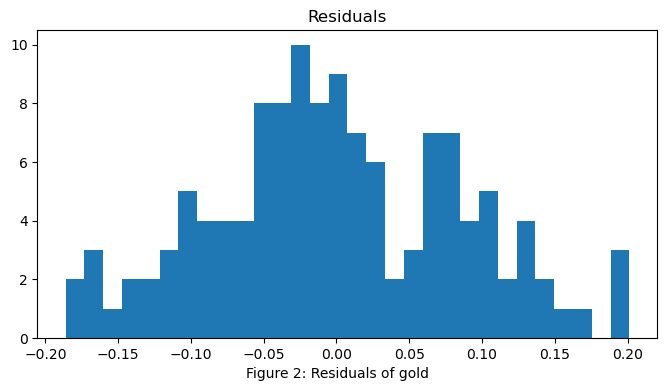

In [398]:
# Plotting the residuals to check for normality
plt.figure(figsize=(8, 4))
plt.title('Residuals')
plt.hist(model.resid, bins=30)
plt.figtext(0.5, 0.01, 'Figure 2: Residuals of gold', ha='center', fontsize=10)
plt.show()

## Bitcoin

In [399]:
# Define the independent variables (add a constant term for the intercept)
X = sm.add_constant(df[['CPI_lag', 'VIX_lag', 'S&P500_lag']])
# Define the dependent variable
y = df['log_btc']

In [400]:
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_btc   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     362.4
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           7.26e-61
Time:                        04:53:46   Log-Likelihood:                -115.34
No. Observations:                 127   AIC:                             238.7
Df Residuals:                     123   BIC:                             250.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.3328      1.958    -20.093      0.0

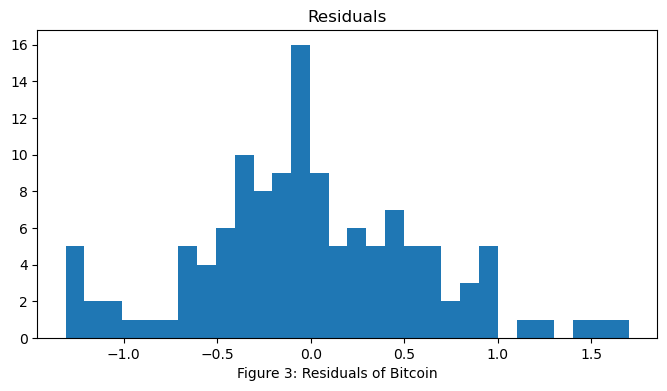

In [402]:
# Plotting the residuals to check for normality
plt.figure(figsize=(8, 4))
plt.title('Residuals')
plt.hist(model.resid, bins=30)
plt.figtext(0.5, 0.01, 'Figure 3: Residuals of Bitcoin', ha='center', fontsize=10)
plt.show()

# GARCH Model 

## Gold

In [403]:
# ADF test 
result_adf = adfuller(df['delta_loggold'], regression='n')  # 'c' for a constant term

# Extract ADF test statistics and p-value
p_value = result_adf[1]
if p_value <= 0.05:
    print("Reject the null hypothesis. The time series of gold is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The time series may be non-stationary.")

Reject the null hypothesis. The time series of gold is likely stationary.


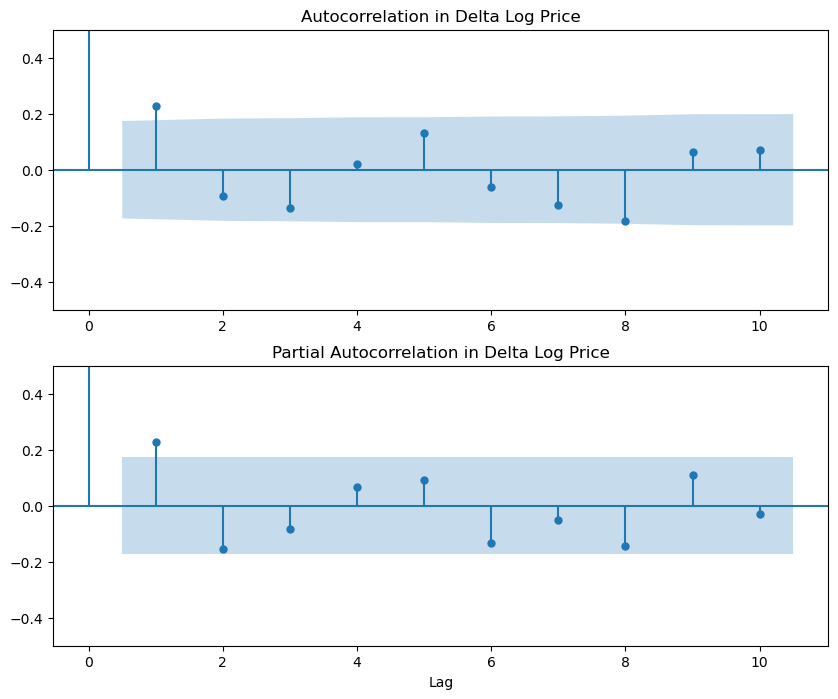

In [404]:
# Plot ACF and PACF

diff_gold = df['delta_loggold']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_gold, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Delta Log Price")
plot_pacf(diff_gold, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Delta Log Price")

plt.show()

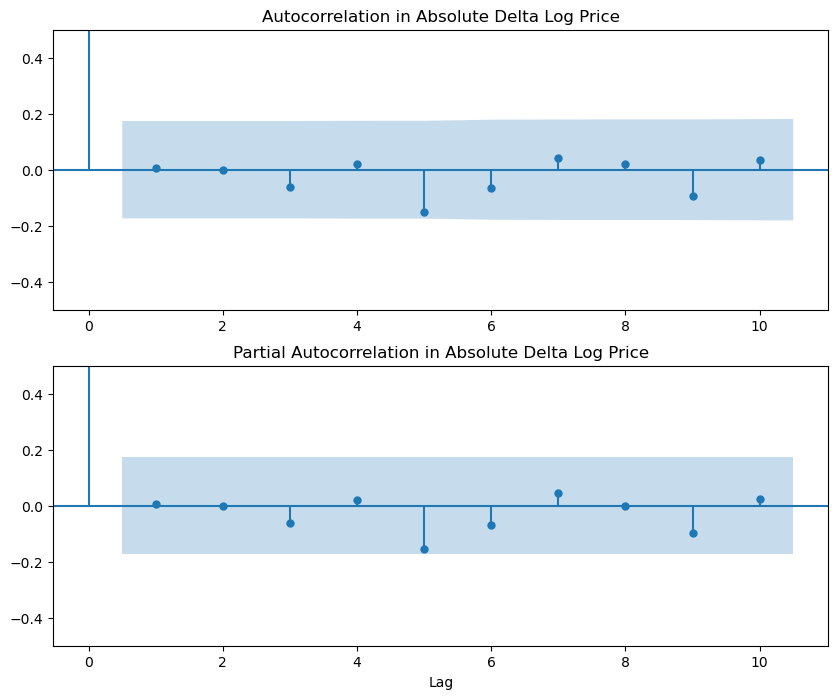

In [405]:
# Plot ACF and PACF of absolute delta log price 
abs_delta_gold = diff_gold.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_delta_gold, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5) 
ax1.set_title("Autocorrelation in Absolute Delta Log Price")
plot_pacf(abs_delta_gold, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)  
ax2.set_title("Partial Autocorrelation in Absolute Delta Log Price")
ax2.set_xlabel("Lag")  

plt.show()


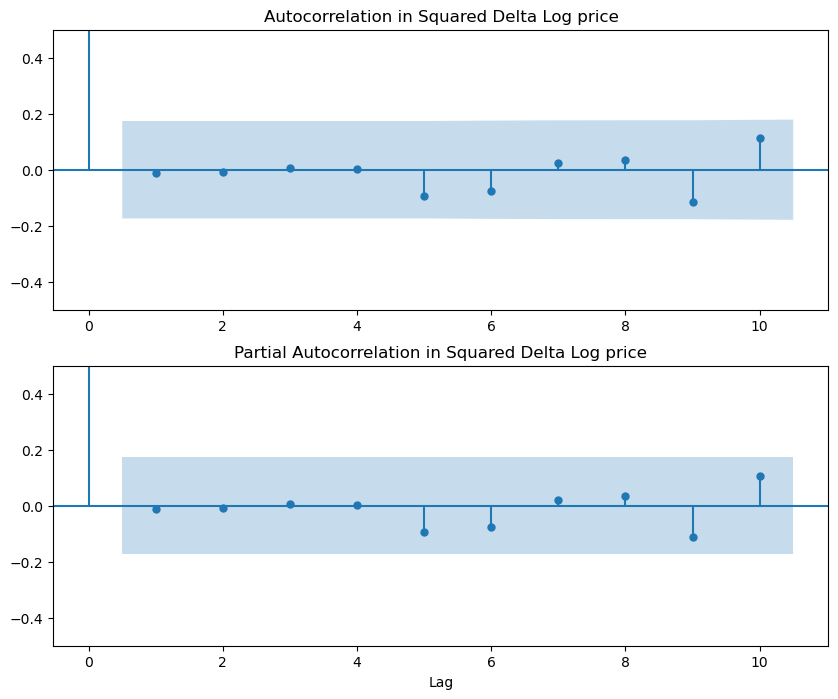

In [406]:
# Plot ACF and PACF of squared delta log price

squared_gold = df['delta_loggold']**2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(squared_gold, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Squared Delta Log price")
plot_pacf(squared_gold, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Squared Delta Log price")

plt.show()

In [407]:
# Define a range of GARCH model orders to test
p_values = [1, 2, 3]  
q_values = [1, 2, 3]  


results_list = []

for p, q in product(p_values, q_values):
    if p == 0 and q == 0:
        continue
        
    model = arch_model(df['delta_loggold'], x=df[['gold_lag1', 'gold_lag2','CPI_lag', 'VIX_lag', 'S&P500_lag']], mean = 'ARX', vol='Garch', p=p, q=q)
    results = model.fit(disp='off')
    aic = results.aic
    bic = results.bic

    
    result_df = pd.DataFrame({"p": [p], "q": [q], "AIC": [aic], "BIC": [bic]})
    
    results_list.append(result_df)

# Concatenate all the DataFrames in the results_list into one DataFrame
results_df = pd.concat(results_list, ignore_index=True)
results_df

,p,q,AIC,BIC
0,1,1,-524.550840,-498.953156
1,1,2,-522.883706,-494.441835
2,1,3,-521.255972,-489.969915
3,2,1,-522.883707,-494.441836
4,2,2,-520.883706,-489.597648
5,2,3,-519.222814,-485.092569
6,3,1,-520.883706,-489.597648
7,3,2,-518.883707,-484.753462
8,3,3,-516.746861,-479.772429


In [408]:
# Find the best AIC and BIC values
best_aic_row = results_df.loc[results_df["AIC"].idxmin()]
best_bic_row = results_df.loc[results_df["BIC"].idxmin()]

print("AIC Results:")
print(best_aic_row)
print("\nBIC Results:")
print(best_bic_row)

AIC Results:
p        1.000000
q        1.000000
AIC   -524.550840
BIC   -498.953156
Name: 0, dtype: float64

BIC Results:
p        1.000000
q        1.000000
AIC   -524.550840
BIC   -498.953156
Name: 0, dtype: float64


In [409]:
exog_vars = df[['gold_lag1', 'gold_lag2','CPI_lag', 'VIX_lag', 'S&P500_lag']]
garch_gold = arch_model(df['delta_loggold'], mean='ARX', vol='Garch', p=1, q=1, dist='Normal', x=exog_vars)
garch_gold = garch_gold.fit(disp='off')
garch_gold

                          AR-X - GARCH Model Results                          
Dep. Variable:          delta_loggold   R-squared:                       0.152
Mean Model:                      AR-X   Adj. R-squared:                  0.117
Vol Model:                      GARCH   Log-Likelihood:                271.275
Distribution:                  Normal   AIC:                          -524.551
Method:            Maximum Likelihood   BIC:                          -498.953
                                        No. Observations:                  127
Date:                Mon, Apr 22 2024   Df Residuals:                      121
Time:                        04:57:01   Df Model:                            6
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.2585      0.132      1.961  4.986e

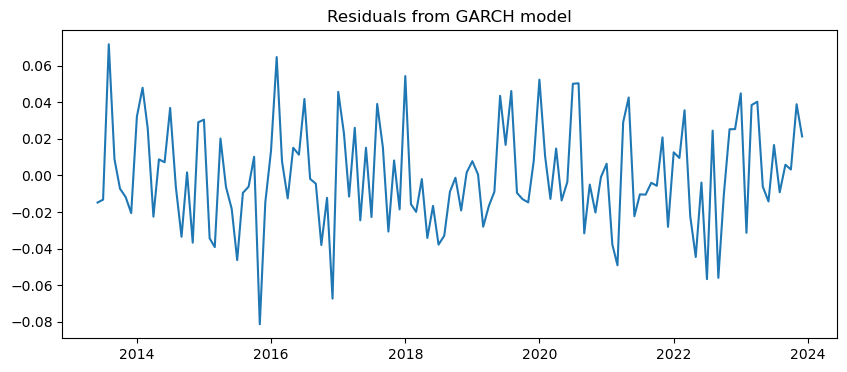

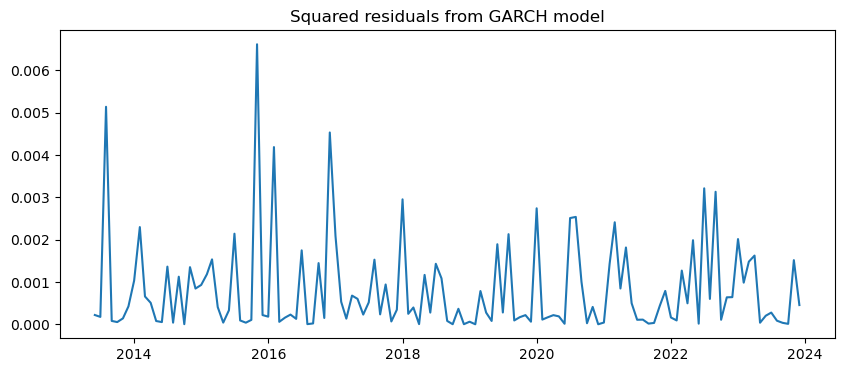

In [410]:
# Plot residuals
plt.figure(figsize=(10,4))
plt.plot(garch_gold.resid)
plt.title('Residuals from GARCH model')
plt.show()

# Plot squared residuals
plt.figure(figsize=(10,4))
plt.plot(garch_gold.resid**2)
plt.title('Squared residuals from GARCH model')
plt.show()

In [411]:
# Square the residuals
squared_residuals_gold = garch_gold.resid ** 2

# Apply the Ljung-Box test on the squared residuals
lb_test = sm.stats.acorr_ljungbox(squared_residuals_gold, lags=[10], return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
10  5.270842   0.872367


## Bitcoin

In [412]:
# ADF test 
result_adf = adfuller(df['delta_logbtc'], regression='n')  # 'c' for a constant term

# Extract ADF test statistics and p-value
p_value = result_adf[1]
if p_value <= 0.05:
    print("Reject the null hypothesis. The time series of gold is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The time series may be non-stationary.")

Reject the null hypothesis. The time series of gold is likely stationary.


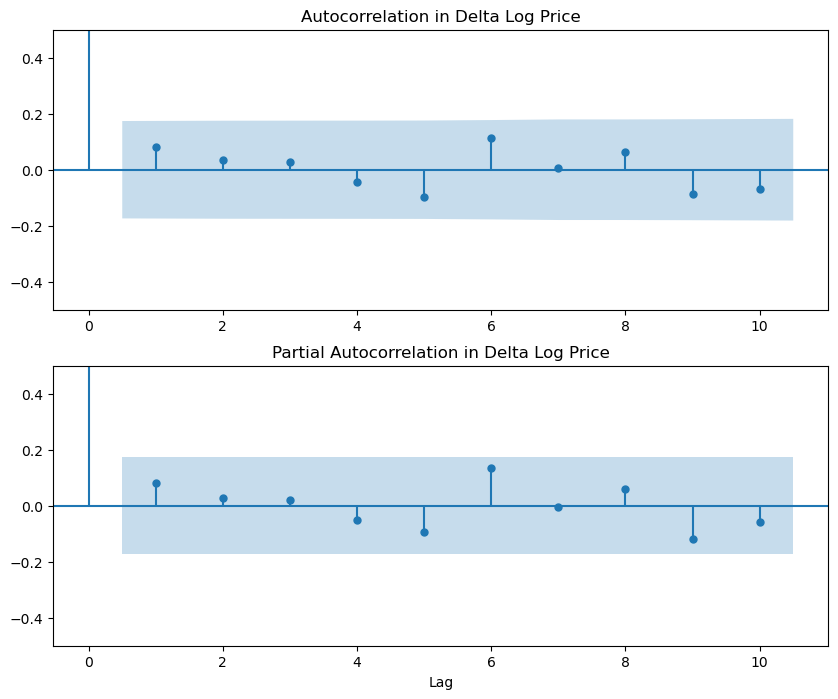

In [413]:
# Plot ACF and PACF

diff_btc = df['delta_logbtc']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_btc, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Delta Log Price")
plot_pacf(diff_btc, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Delta Log Price")

plt.show()

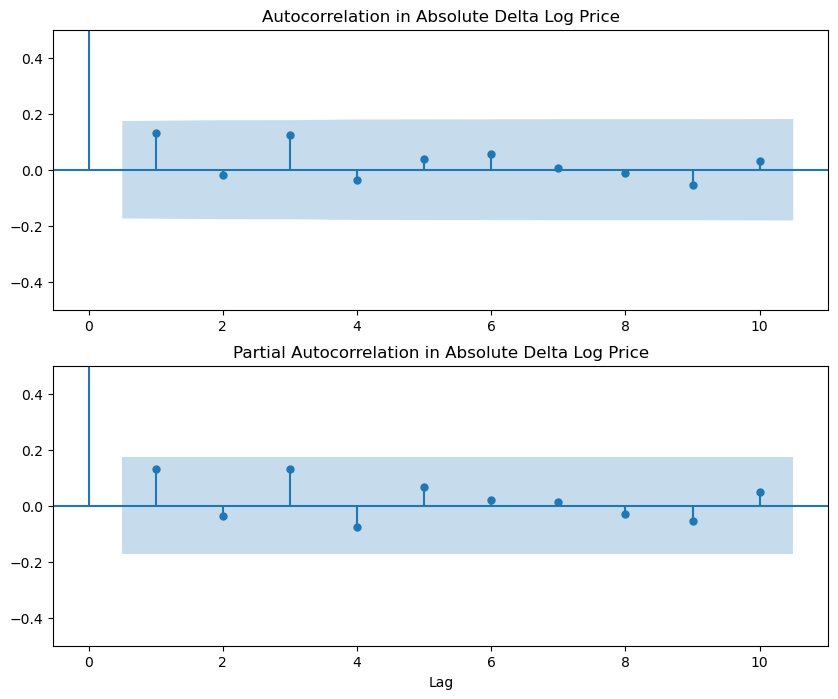

In [414]:
# Plot ACF and PACF of absolute delta log price 
abs_delta_btc = diff_btc.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_delta_btc, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5) 
ax1.set_title("Autocorrelation in Absolute Delta Log Price")
plot_pacf(abs_delta_btc, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)  
ax2.set_title("Partial Autocorrelation in Absolute Delta Log Price")
ax2.set_xlabel("Lag")  

plt.show()


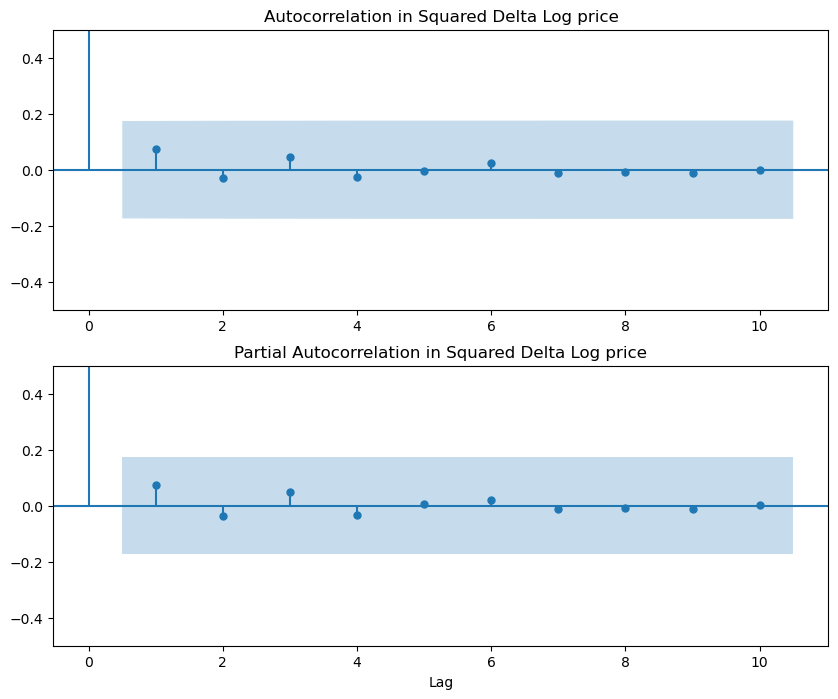

In [415]:
# Plot ACF and PACF of squared delta log price

squared_btc = df['delta_logbtc']**2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(squared_btc, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Squared Delta Log price")
plot_pacf(squared_btc, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Squared Delta Log price")

plt.show()

In [416]:
# Define a range of GARCH model orders to test
p_values = [1, 2, 3]  
q_values = [1, 2, 3]  


results_list = []

for p, q in product(p_values, q_values):
    if p == 0 and q == 0:
        continue
        
    model = arch_model(df['delta_logbtc'], x=df[['btc_lag1', 'btc_lag2','CPI_lag', 'VIX_lag', 'S&P500_lag']], mean = 'ARX', vol='Garch', p=p, q=q)
    results = model.fit(disp='off')
    aic = results.aic
    bic = results.bic

    
    result_df = pd.DataFrame({"p": [p], "q": [q], "AIC": [aic], "BIC": [bic]})
    
    results_list.append(result_df)

# Concatenate all the DataFrames in the results_list into one DataFrame
results_df = pd.concat(results_list, ignore_index=True)
results_df

,p,q,AIC,BIC
0,1,1,0.601407,26.199091
1,1,2,2.370539,30.812410
2,1,3,4.370539,35.656597
3,2,1,2.601407,31.043278
4,2,2,4.370541,35.656599
5,2,3,6.000495,40.130740
6,3,1,4.601407,35.887465
7,3,2,6.370542,40.500787
8,3,3,7.960249,44.934682


In [417]:
# Find the best AIC and BIC values
best_aic_row = results_df.loc[results_df["AIC"].idxmin()]
best_bic_row = results_df.loc[results_df["BIC"].idxmin()]

print("AIC Results:")
print(best_aic_row)
print("\nBIC Results:")
print(best_bic_row)

AIC Results:
p       1.000000
q       1.000000
AIC     0.601407
BIC    26.199091
Name: 0, dtype: float64

BIC Results:
p       1.000000
q       1.000000
AIC     0.601407
BIC    26.199091
Name: 0, dtype: float64


In [418]:
exog_vars = df[['btc_lag1', 'btc_lag2','CPI_lag', 'VIX_lag', 'S&P500_lag']]
garch_btc = arch_model(df['delta_logbtc'], mean='ARX', vol='Garch', p=1, q=1, dist='Normal', x=exog_vars)
garch_btc = garch_btc.fit(disp='off')
garch_btc

                          AR-X - GARCH Model Results                          
Dep. Variable:           delta_logbtc   R-squared:                       0.051
Mean Model:                      AR-X   Adj. R-squared:                  0.012
Vol Model:                      GARCH   Log-Likelihood:                8.69930
Distribution:                  Normal   AIC:                          0.601407
Method:            Maximum Likelihood   BIC:                           26.1991
                                        No. Observations:                  127
Date:                Mon, Apr 22 2024   Df Residuals:                      121
Time:                        04:59:05   Df Model:                            6
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const         -2.8753      1.833     -1.569      0.1

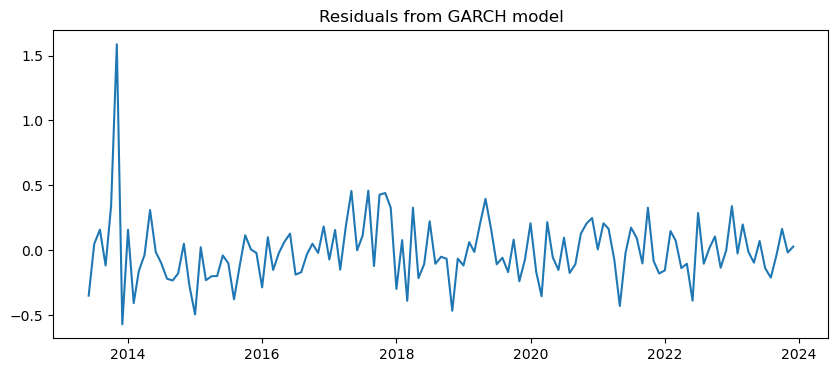

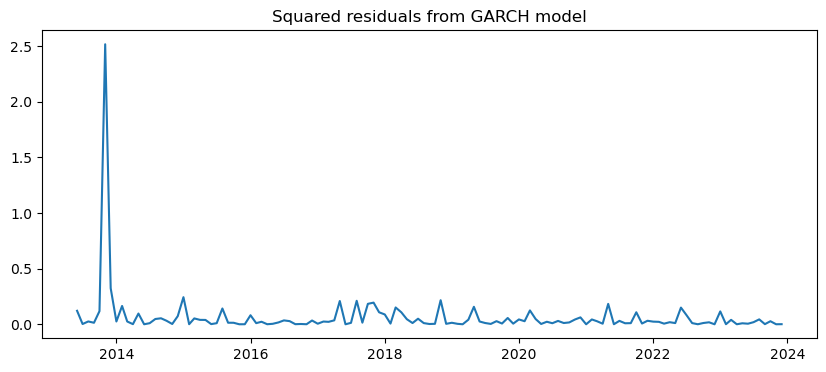

In [419]:
# Plot residuals
plt.figure(figsize=(10,4))
plt.plot(garch_btc.resid)
plt.title('Residuals from GARCH model')
plt.show()

# Plot squared residuals
plt.figure(figsize=(10,4))
plt.plot(garch_btc.resid**2)
plt.title('Squared residuals from GARCH model')
plt.show()

In [420]:
# Square the residuals
squared_residuals_btc = garch_btc.resid ** 2

# Apply the Ljung-Box test on the squared residuals
lb_test = sm.stats.acorr_ljungbox(squared_residuals_btc, lags=[10], return_df=True)
print(lb_test)

    lb_stat  lb_pvalue
10  2.52257   0.990543


# Robustness test

## Gold 

In [429]:
# Define a range of GARCH model orders to test
p_values = [1, 2, 3]  
q_values = [1, 2, 3]  


results_list = []

for p, q in product(p_values, q_values):
    if p == 0 and q == 0:
        continue
        
    model = arch_model(df['delta_loggold'], x=df[['gold_lag1', 'gold_lag2','CPI_lag','bond_lag']], mean = 'ARX', vol='Garch', p=p, q=q)
    results = model.fit(disp='off')
    aic = results.aic
    bic = results.bic

    
    result_df = pd.DataFrame({"p": [p], "q": [q], "AIC": [aic], "BIC": [bic]})
    
    results_list.append(result_df)

# Concatenate all the DataFrames in the results_list into one DataFrame
results_df = pd.concat(results_list, ignore_index=True)
results_df

,p,q,AIC,BIC
0,1,1,-514.999386,-492.245890
1,1,2,-512.993478,-487.395794
2,1,3,-510.899458,-482.457587
3,2,1,-513.053059,-487.455375
4,2,2,-510.903845,-482.461974
5,2,3,-508.997643,-477.711585
6,3,1,-511.637710,-483.195839
7,3,2,-509.637702,-478.351644
8,3,3,-507.637683,-473.507438


In [422]:
# Find the best AIC and BIC values
best_aic_row = results_df.loc[results_df["AIC"].idxmin()]
best_bic_row = results_df.loc[results_df["BIC"].idxmin()]

print("AIC Results:")
print(best_aic_row)
print("\nBIC Results:")
print(best_bic_row)

AIC Results:
p        1.000000
q        1.000000
AIC   -514.999386
BIC   -492.245890
Name: 0, dtype: float64

BIC Results:
p        1.000000
q        1.000000
AIC   -514.999386
BIC   -492.245890
Name: 0, dtype: float64


In [423]:
exog_vars = df[['gold_lag1', 'gold_lag2','CPI_lag','bond_lag']]
garch_gold = arch_model(df['delta_loggold'], mean='ARX', vol='Garch', p=1, q=1, dist='Normal', x=exog_vars)
garch_gold = garch_gold.fit(disp='off')
garch_gold

                          AR-X - GARCH Model Results                          
Dep. Variable:          delta_loggold   R-squared:                       0.067
Mean Model:                      AR-X   Adj. R-squared:                  0.037
Vol Model:                      GARCH   Log-Likelihood:                265.500
Distribution:                  Normal   AIC:                          -514.999
Method:            Maximum Likelihood   BIC:                          -492.246
                                        No. Observations:                  127
Date:                Mon, Apr 22 2024   Df Residuals:                      122
Time:                        05:01:11   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.1159      0.134      0.862      0.389 

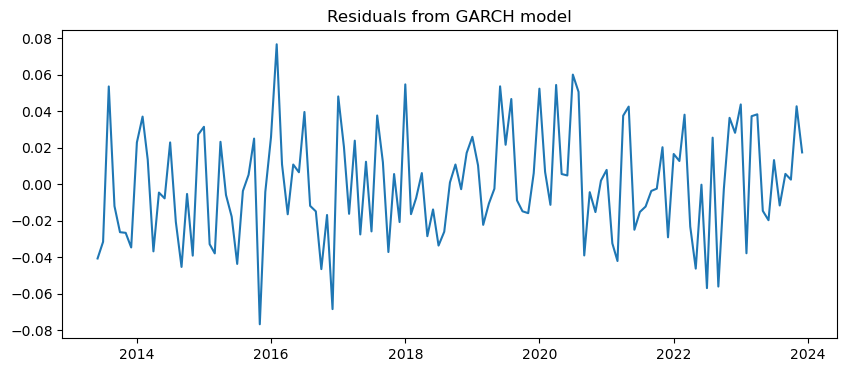

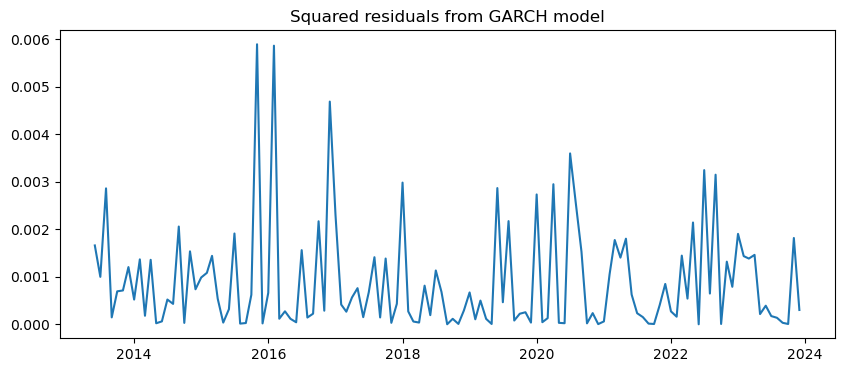

In [424]:
# Plot residuals
plt.figure(figsize=(10,4))
plt.plot(garch_gold.resid)
plt.title('Residuals from GARCH model')
plt.show()

# Plot squared residuals
plt.figure(figsize=(10,4))
plt.plot(garch_gold.resid**2)
plt.title('Squared residuals from GARCH model')
plt.show()

## Bitcoin

In [430]:
# Define a range of GARCH model orders to test
p_values = [1, 2, 3]  
q_values = [1, 2, 3]  


results_list = []

for p, q in product(p_values, q_values):
    if p == 0 and q == 0:
        continue
        
    model = arch_model(df['delta_logbtc'], x=df[['btc_lag1', 'btc_lag2','CPI_lag', 'bond_lag']], mean = 'ARX', vol='Garch', p=p, q=q)
    results = model.fit(disp='off')
    aic = results.aic
    bic = results.bic

    
    result_df = pd.DataFrame({"p": [p], "q": [q], "AIC": [aic], "BIC": [bic]})
    
    results_list.append(result_df)

# Concatenate all the DataFrames in the results_list into one DataFrame
results_df = pd.concat(results_list, ignore_index=True)
results_df

,p,q,AIC,BIC
0,1,1,1.657087,24.410583
1,1,2,3.534243,29.131927
2,1,3,5.534243,33.976114
3,2,1,3.657086,29.254769
4,2,2,5.534243,33.976114
5,2,3,7.194133,38.480190
6,3,1,5.657086,34.098957
7,3,2,7.534243,38.820301
8,3,3,9.194133,43.324378


In [426]:
# Find the best AIC and BIC values
best_aic_row = results_df.loc[results_df["AIC"].idxmin()]
best_bic_row = results_df.loc[results_df["BIC"].idxmin()]

print("AIC Results:")
print(best_aic_row)
print("\nBIC Results:")
print(best_bic_row)

AIC Results:
p       1.000000
q       1.000000
AIC     1.657087
BIC    24.410583
Name: 0, dtype: float64

BIC Results:
p       1.000000
q       1.000000
AIC     1.657087
BIC    24.410583
Name: 0, dtype: float64


In [427]:
exog_vars = df[['btc_lag1', 'btc_lag2','CPI_lag', 'bond_lag']]
garch_btc = arch_model(df['delta_logbtc'], mean='ARX', vol='Garch', p=1, q=1, dist='Normal', x=exog_vars)
garch_btc = garch_btc.fit(disp='off')
garch_btc

                          AR-X - GARCH Model Results                          
Dep. Variable:           delta_logbtc   R-squared:                       0.030
Mean Model:                      AR-X   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:                7.17146
Distribution:                  Normal   AIC:                           1.65709
Method:            Maximum Likelihood   BIC:                           24.4106
                                        No. Observations:                  127
Date:                Mon, Apr 22 2024   Df Residuals:                      122
Time:                        05:02:10   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.1089      0.112      0.972      0.331 

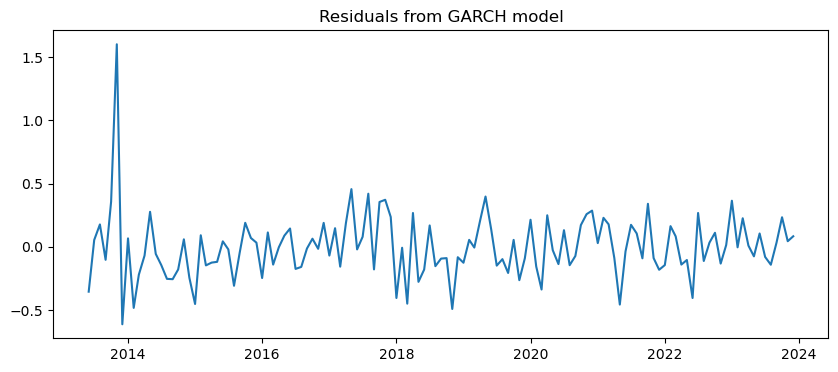

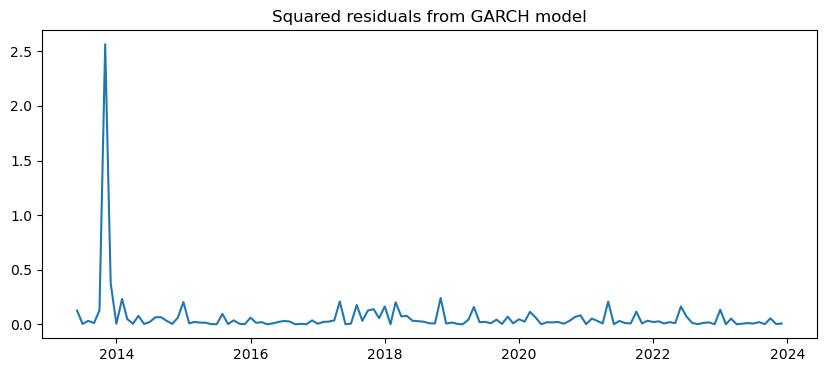

In [428]:
# Plot residuals
plt.figure(figsize=(10,4))
plt.plot(garch_btc.resid)
plt.title('Residuals from GARCH model')
plt.show()

# Plot squared residuals
plt.figure(figsize=(10,4))
plt.plot(garch_btc.resid**2)
plt.title('Squared residuals from GARCH model')
plt.show()